# CV Project 2 - Snake Classification using CNNs
## Nishai Kooverjee (1354477) & Matt Cockcroft (1415624)

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn as nn
import cv2
from PIL import Image
import os
from shutil import copyfile
import copy
import fastai
from sklearn.metrics import f1_score, cohen_kappa_score, accuracy_score
import pylab
from tqdm import tqdm_notebook as tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

import warnings
warnings.filterwarnings("ignore")

### Data Preprocessing

Split the data into training, validation and test sets using a 70%, 15%, 15% split. 

Verify all the images and remove any broken images (there were over 200 broken images that were removed).

In [78]:
directories = ['./data/train', './data/val', './data/test']

for d in directories:
    if not os.path.exists(d):
        os.makedirs(d)
        
for i in os.listdir("./train"):
    if not os.path.exists(os.path.join(directories[0], i)):
        os.makedirs(os.path.join(directories[0], i))
    if not os.path.exists(os.path.join(directories[1], i)):
        os.makedirs(os.path.join(directories[1], i))
    if not os.path.exists(os.path.join(directories[2], i)):
        os.makedirs(os.path.join(directories[2], i))    
        
fractions = {'train': 0.7,'val': 0.15,'test': 0.15}

# Split the data

for folder in tqdm(os.listdir("./train"), desc='Folders'):
    curr_path = os.path.join("./train/", folder)
    images = os.listdir(curr_path)
    num_images = len(images)

    for i in tqdm(range(num_images), leave=False, desc=folder):
        if i <= (num_images * fractions['train']):
            copyfile(os.path.join(curr_path, images[i]) , os.path.join(os.path.join(directories[0], folder), images[i]))
        elif i <= (num_images * (fractions['train'] + fractions['val'])):
            copyfile(os.path.join(curr_path, images[i]) , os.path.join(os.path.join(directories[1], folder), images[i]))
        else:
            copyfile(os.path.join(curr_path, images[i]) , os.path.join(os.path.join(directories[2], folder), images[i]))

# Verify images and remove broken images

for root in directories:
    for i in listdir(root):
        for j in listdir(os.path.join(root, i)):
            try:
                img = Image.open(os.path.join(os.path.join(root, i), j))
                img.verify()
            except (IOError, SyntaxError) as e:
                if os.path.exists(os.path.join(os.path.join(root, i), j)):
                    os.remove(os.path.join(os.path.join(root, i), j))

### Transforms

#### Transforms on all sets:
* Resized to 224x224
* Normalise intensities
* Convert images to PyTorch tensor
* Crop images

#### Training set transforms:
* Random rotation between 0 and 90 degrees
* Random horizontal flip
* Random resized crop

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation([0, 90]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Creating DataLoaders

In [3]:
# Define directories
train_dir = './data/train/'
validation_dir = './data/val/'
test_dir = './data/test/'

# Define datasets
training_set = torchvision.datasets.ImageFolder(train_dir, data_transforms['train'])
validation_set = torchvision.datasets.ImageFolder(train_dir, data_transforms['val'])
test_set = torchvision.datasets.ImageFolder(train_dir, data_transforms['test'])

# batch-size
bs = 16

# Define DataLoaders                               
train_loader = torch.utils.data.DataLoader(training_set, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)

### Dealing with class imbalance
Some classes have many more images than other classes. To deal with this we determine the proportions of each class w.r.t each other. These serve as weights to our loss function.

In [82]:
C = len(training_set.classes)
number_of_training_samples = len(training_set)

class_balance = torch.empty(C)
for i, cl in enumerate(training_set.classes):
    class_balance[i] = 1/len(os.listdir(os.path.join(train_dir, cl)))/number_of_training_samples

normalization_factor = class_balance.sum()
class_balance /= normalization_factor
class_balance = class_balance.to(device)
print(class_balance)

criterion = nn.CrossEntropyLoss(weight=class_balance)

tensor([0.0280, 0.0333, 0.0167, 0.0149, 0.0022, 0.0368, 0.0429, 0.0391, 0.0072,
        0.0116, 0.0109, 0.0202, 0.0167, 0.0097, 0.0249, 0.0179, 0.0121, 0.0396,
        0.0183, 0.0237, 0.0181, 0.0469, 0.0131, 0.0248, 0.0473, 0.0210, 0.0114,
        0.0349, 0.0233, 0.0261, 0.0078, 0.0054, 0.0217, 0.0293, 0.0419, 0.0045,
        0.0117, 0.0482, 0.0098, 0.0274, 0.0141, 0.0220, 0.0045, 0.0414, 0.0170])


### Load pre-trained networks

We fine-tune `torch`'s bundled pre-trained networks for AlexNet, ResNet-18, and MobileNet-v2 to train our models.

In [86]:
model_type = 'mobilenet'

if model_type =='resnet':
    model = torchvision.models.resnet18(pretrained=True, progress=True)

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, C)
    
elif model_type == 'alexnet':
    model = torchvision.models.alexnet(pretrained=True, progress=True)

    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, C)

elif model_type == 'mobilenet':
    model = torchvision.models.mobilenet_v2(pretrained=True, progress=True)

    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, C)

print(model)
# train all parameters (fine-tuning)
for name,param in model.named_parameters():        
    param.requires_grad = True

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [9]:
# Use Adam as optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=3e-4)

# Scheduler for learning rate
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

### Training networks

We train the nets for 10 epochs, and compute the loss, accuracy and F1-score for training and validation sets at every epoch. The models are saved at every epoch and the best model is returned at the end of training.

In [130]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=10):
    
    val_acc_history = []
    train_dict = {'loss':[],'acc':[],'f':[]}
    val_dict = {'loss':[],'acc':[],'f':[]}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_fscore = 0.0
    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            f_score_list = []

            for inputs, labels in tqdm(dataloaders[phase], leave=False, desc='Training'):
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                   
                labels_cpu = labels.cpu().numpy()
                predictions_cpu = preds.cpu().numpy()
                F_score = f1_score(labels_cpu, predictions_cpu, average='macro') 
                f_score_list.append(F_score)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_f_score = np.average(np.array(f_score_list))
            print('{} Loss: {:.4f} Acc: {:.4f} F: {:.3f}'.format(phase, epoch_loss, epoch_acc, epoch_f_score))

    
            if phase == 'val' and epoch_f_score > best_fscore:
                best_fscore = epoch_f_score 
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'val':
                torch.save(model.state_dict(), './saved_models/resnet/resnet_snakes_drop_Ep_{}_Acc_{:.3f}_F_{:.3f}.pth'.format(epoch,epoch_acc, epoch_f_score))
                val_acc_history.append(epoch_acc)
                val_dict['loss'].append(epoch_loss)
                val_dict['acc'].append(epoch_acc)
                val_dict['f'].append(epoch_f_score)
            else:
                train_dict['loss'].append(epoch_loss)
                train_dict['acc'].append(epoch_acc)
                train_dict['f'].append(epoch_f_score)
    
    model.load_state_dict(best_model_wts)
    return model, train_dict, val_dict

In [127]:
dataloaders_dict = {'train':train_loader, 'val':val_loader}
model = model.to(device)

# Train and evaluate
model, train_hist, val_hist = train_model(model, dataloaders_dict, criterion, optimizer, device)

val_df = pd.DataFrame(val_hist).T
train_df = pd.DataFrame(train_hist).T

In [140]:
# write results to csv files
val_df.to_csv(r'./results/{}_val.csv'.format(model_type))
train_df.to_csv(r'./results/{}_train.csv'.format(model_type))

## Evaluating Models
### Graphs

In [43]:
# read csvs into DataFrames
val_dfs={}
train_dfs={}

for mt in ['alexnet', 'resnet', 'mobilenet']:
    val_dfs[mt] = pd.read_csv('results/{}_val.csv'.format(mt), index_col=0)
    train_dfs[mt] = pd.read_csv('results/{}_train.csv'.format(mt), index_col=0)
    
sns.set_style('darkgrid')
mts = ['alexnet', 'resnet', 'mobilenet'] # model_types
colours = ['turquoise', 'coral', 'violet'] # colours to plot with
labels = ['AlexNet', 'ResNet-18', 'MobileNet-v2'] # labels for legend

#### Training set

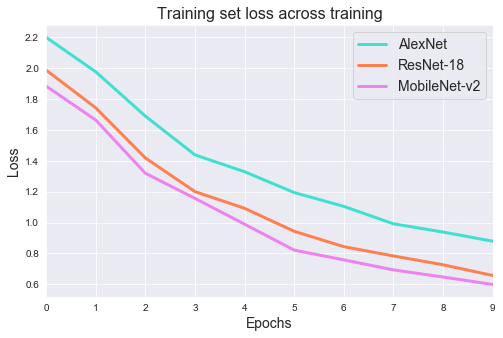

In [49]:
plt.figure(figsize=(8,5))
for mt, col, lab in zip(mts, colours, labels):
    train_dfs[mt].loc['loss'].plot(label=lab, color=col, lw=3)
    
plt.title('Training set loss across training', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.legend(fontsize=14)
plt.show()

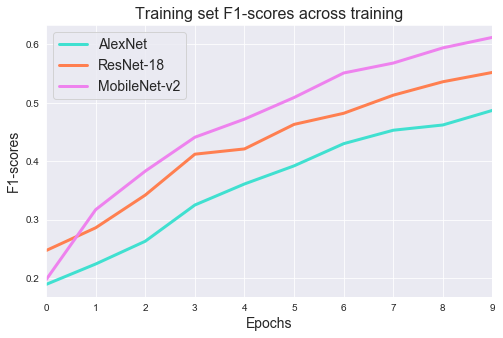

In [50]:
plt.figure(figsize=(8,5))
for mt, col, lab in zip(mts,colours, labels):
    train_dfs[mt].loc['f'].plot(label=lab, color=col, lw=3)
    
plt.title('Training set F1-scores across training', fontsize=16)
plt.ylabel('F1-scores', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.legend(fontsize=14)
plt.show()

#### Validation set

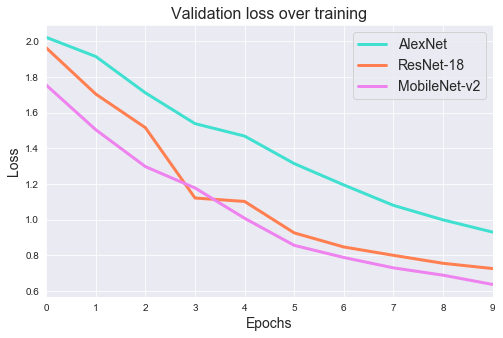

In [44]:
plt.figure(figsize=(8,5))
for mt, col, lab in zip(mts,colours, labels):
    val_dfs[mt].loc['loss'].plot(label=lab, color=col, lw=3)
    
plt.title('Validation loss over training', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.legend(fontsize=14)
plt.show()

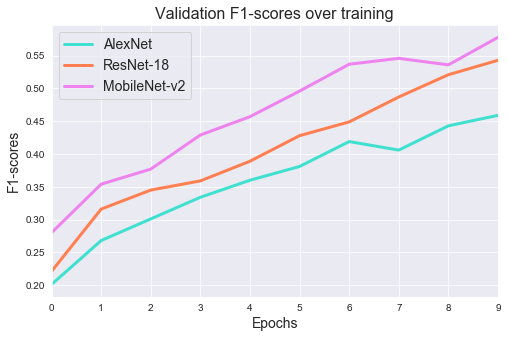

In [45]:
plt.figure(figsize=(8,5))
for mt, col, lab in zip(mts,colours, labels):
    val_dfs[mt].loc['f'].plot(label=lab, color=col, lw=3)
    
plt.title('Validation F1-scores over training', fontsize=16)
plt.ylabel('F1-scores', fontsize=14)

plt.xlabel('Epochs', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Confusion Matrices
Use our training set DataLoader to generate confusion matrices for each of the networks.

In [76]:
model_weights = torch.load('./saved_models/mobilenet_v2/mobilenet_Ep_10_Acc_0.699_F_0.578.pth')
model.load_state_dict(model_weights)

model.eval()
model = model.to(device)

predictions_list=[]
labels_list=[]

cm = np.zeros((C,C))
for inputs, labels in tqdm(test_loader):
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    preds = preds.cpu()
    predictions_list.append(preds)
    labels_list.append(labels)
    indices = torch.eq(labels, preds).numpy()

    wrong_classification = np.where(indices == 0)
    correct_classification = np.where(indices == 1)

    for i in wrong_classification[0]:
        cm[labels[i], preds[i].item()] += 1
    
    for i in correct_classification[0]:
        cm[labels[i],preds[i].item()] += 1
    
df_cm = pd.DataFrame(cm, index = [i for i in range(0, C)],
                  columns = [i for i in range(0, C)])

### AlexNet

In [52]:
accuracy_score(labels_list, predictions_list)

0.325


In [53]:
f1_score(labels_list, predictions_list)

0.283


Text(0.5, 51.0, 'Predicted labels')

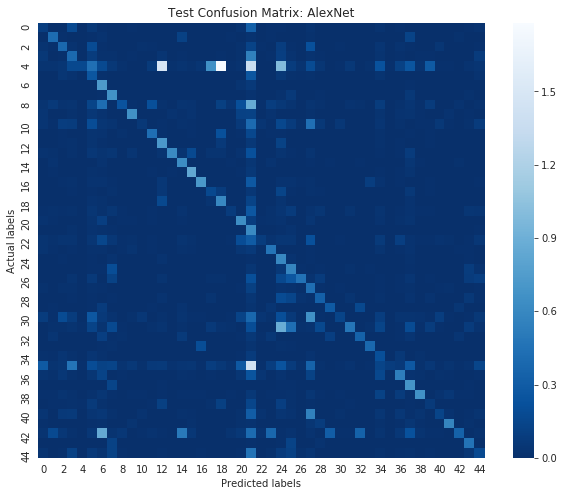

In [77]:
plt.figure(figsize = (10,8))
sns.heatmap(df_cm/df_cm.sum(axis=1), annot=False, cmap='Blues_r')
plt.title('Test Confusion Matrix: AlexNet')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')

### ResNet-18

In [54]:
accuracy_score(labels_list, predictions_list)

0.497


In [55]:
f1_score(labels_list, predictions_list)

0.401


Text(0.5, 51.0, 'Predicted labels')

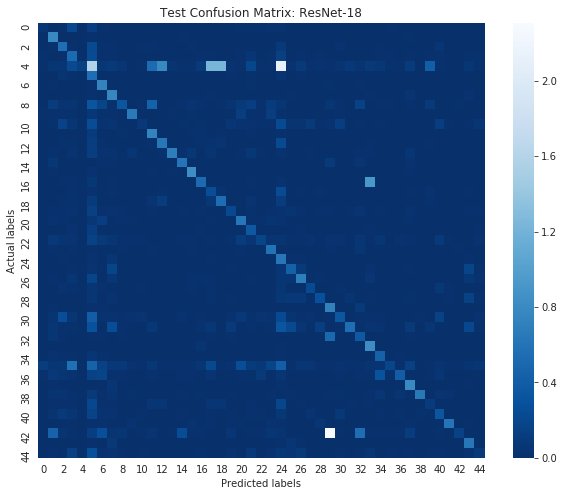

In [75]:
plt.figure(figsize = (10,8))
sns.heatmap(df_cm/df_cm.sum(axis=1), annot=False, cmap='Blues_r')
plt.title('Test Confusion Matrix: ResNet-18')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')

### MobileNet V2

In [57]:
accuracy_score(labels_list, predictions_list)

0.543

In [58]:
f1_score(labels_list, predictions_list)

0.452

Text(0.5, 51.0, 'Predicted labels')

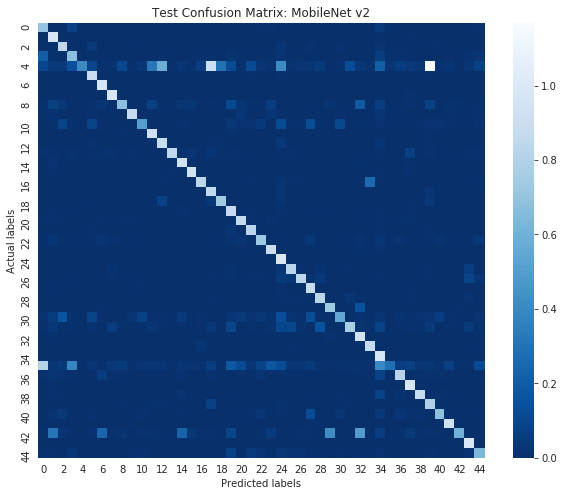

In [71]:
plt.figure(figsize = (10,8))
sns.heatmap(df_cm/df_cm.sum(axis=1), annot=False, cmap='Blues_r')
plt.title('Test Confusion Matrix: MobileNet v2')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')